Enter job title to search: data analyst
Enter location (city/state/country): kerala

Fetching 'data analyst' jobs in kerala...


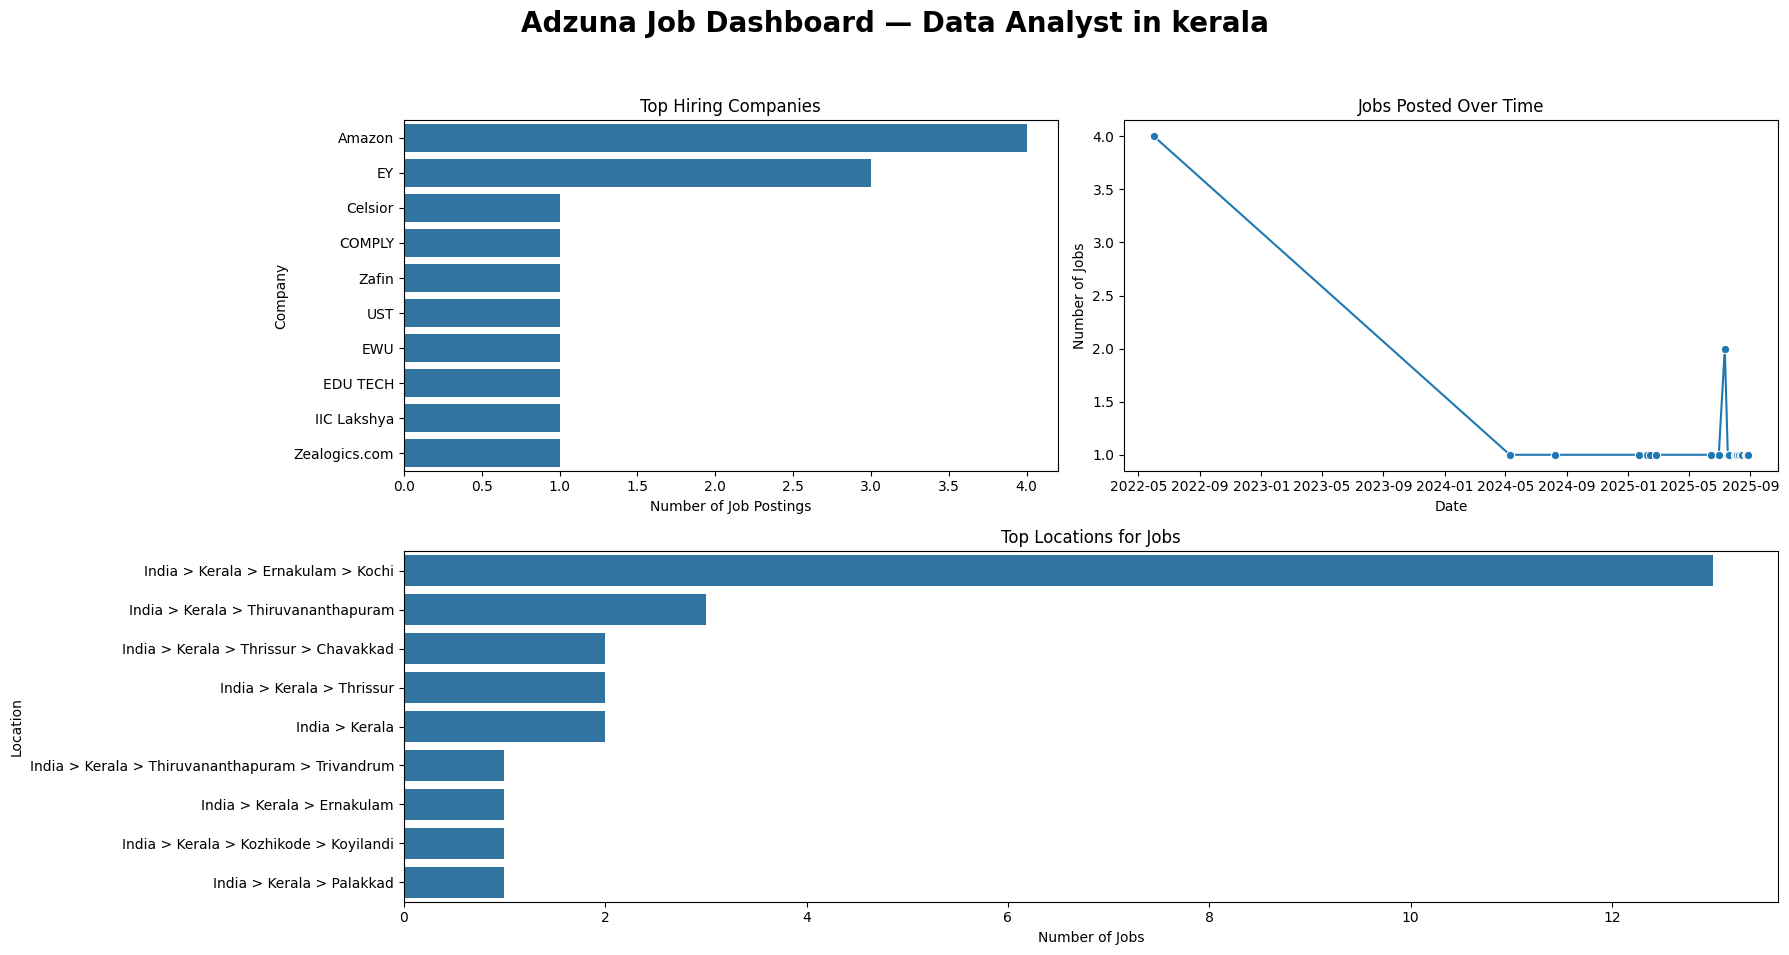

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
APP_ID = "56292f31"   # your Adzuna App ID
APP_KEY = "00f70452a2b97e9665946e30d49623f7"  # your Adzuna App Key
COUNTRY = "in"  # "in" = India, "us" = USA, etc.

# -----------------------------
# USER INPUT
# -----------------------------
QUERY = input("Enter job title to search: ").strip()
PLACE = input("Enter location (city/state/country): ").strip()

API_URL = f"https://api.adzuna.com/v1/api/jobs/{COUNTRY}/search/1"
PARAMS = {
    "app_id": APP_ID,
    "app_key": APP_KEY,
    "results_per_page": 50,
    "what": QUERY,
    "where": PLACE,
}

# -----------------------------
# FETCH DATA
# -----------------------------
print(f"\nFetching '{QUERY}' jobs in {PLACE}...")
resp = requests.get(API_URL, params=PARAMS)

if resp.status_code != 200:
    print("Error fetching data:", resp.status_code, resp.text)
else:
    data = resp.json()
    jobs = data.get("results", []) or []

    if not jobs:
        print("No jobs found. Try a different keyword or location "
              "(e.g., check spelling like 'Bangalore').")
    else:
        # -----------------------------
        # PROCESS DATA (SAFE)
        # -----------------------------
        df = pd.DataFrame(jobs)

        # created (safe even if column missing)
        if "created" in df.columns:
            df["created"] = pd.to_datetime(df["created"], errors="coerce")
        else:
            df["created"] = pd.to_datetime(pd.Series([None] * len(df)), errors="coerce")

        # company_name
        if "company" in df.columns:
            df["company_name"] = df["company"].apply(
                lambda x: x.get("display_name") if isinstance(x, dict) else None
            )
        else:
            df["company_name"] = None

        # location_area
        if "location" in df.columns:
            df["location_area"] = df["location"].apply(
                lambda x: " > ".join(x.get("area", [])) if isinstance(x, dict) else None
            )
        else:
            df["location_area"] = None

        # -----------------------------
        # ANALYSIS
        # -----------------------------
        top_companies = df["company_name"].value_counts(dropna=True).nlargest(10)

        jobs_per_day = (
            df["created"]
            .dropna()
            .dt.date.value_counts()
            .sort_index()
        )

        top_locations = df["location_area"].value_counts(dropna=True).nlargest(10)

        # -----------------------------
        # VISUALIZATION DASHBOARD (robust to empty series)
        # -----------------------------
        plt.figure(figsize=(18, 10))
        plt.suptitle(f"Adzuna Job Dashboard — {QUERY.title()} in {PLACE}",
                     fontsize=20, weight="bold")

        # Top Companies
        plt.subplot(2, 2, 1)
        if len(top_companies) > 0:
            sns.barplot(x=top_companies.values, y=top_companies.index)
            plt.xlabel("Number of Job Postings")
            plt.ylabel("Company")
        else:
            plt.text(0.5, 0.5, "No company data", ha="center", va="center")
            plt.xticks([]); plt.yticks([])
        plt.title("Top Hiring Companies")

        # Jobs per day
        plt.subplot(2, 2, 2)
        if len(jobs_per_day) > 0:
            sns.lineplot(x=list(jobs_per_day.index), y=list(jobs_per_day.values), marker="o")
            plt.xlabel("Date")
            plt.ylabel("Number of Jobs")
        else:
            plt.text(0.5, 0.5, "No date data", ha="center", va="center")
            plt.xticks([]); plt.yticks([])
        plt.title("Jobs Posted Over Time")

        # Top Locations
        plt.subplot(2, 1, 2)
        if len(top_locations) > 0:
            sns.barplot(x=top_locations.values, y=top_locations.index)
            plt.xlabel("Number of Jobs")
            plt.ylabel("Location")
        else:
            plt.text(0.5, 0.5, "No location data", ha="center", va="center")
            plt.xticks([]); plt.yticks([])
        plt.title("Top Locations for Jobs")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()